# Autoencoder
This notebook makes use of the **Autoencoder**, which is used to reduce the dimensionality of our dataset in a non-linear way. Furthermore, we then apply **k-means Clustering** as in our last notebook in our new created **Latent Space** in lower dimension. We do so, to get rid of less important variables and achieve a better Clustering.

In [1]:
!pip install -q -r ../../requirements.txt &> /dev/null

In [2]:
from ipywidgets import FloatSlider
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from ipywidgets import interact, IntSlider
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.dates as mdates

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset

import sys
sys.path.append('../..')
import helper_functions     # Own file.
import importlib
importlib.reload(helper_functions)

<module 'helper_functions' from '/home/jovyan/spatiotemporal-mining-medsea/information_filtering/no_trend_removement/models/../../helper_functions.py'>

## Data Loading & Preprocessing

In [3]:
ds = xr.open_dataset("/home/jovyan/spatiotemporal-mining-medsea/data/medsea.nc")
print(ds.nbytes / 1e6, "MB")

z_temp = helper_functions.preprocessing(ds, ["thetao", "so"], [50, 300, 1000], "location", False, -1)
print(z_temp.shape)
X = z_temp.values
input_dimension = X.shape[1]

20554.545012 MB
(342, 167042)


## Splitting

In [4]:
X = X.astype(np.float32)
X_train, X_test = train_test_split(X, test_size=0.1, random_state=27)

train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train)), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.from_numpy(X_test)), batch_size=64, shuffle=False)

## The Architecture

In [5]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()

        # Encoder for mean and logvar
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(0.1),
            nn.LeakyReLU(),

            nn.Linear(512, 32),
            nn.BatchNorm1d(32),
            nn.Dropout(0.1),
            nn.LeakyReLU()
        )
        self.fc_mean = nn.Linear(32, latent_dim)
        self.fc_logvar = nn.Linear(32, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),

            nn.Linear(32, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),

            nn.Linear(512, input_dim)
        )

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        h = self.encoder(x)
        z_mean = self.fc_mean(h)
        z_logvar = self.fc_logvar(h)
        z = self.reparameterize(z_mean, z_logvar)
        x_recon = self.decoder(z)
        return x_recon, z_mean, z_logvar

## Training Loop

In [6]:
def train(num_epochs: int, kl_annealing_epochs: int = 50, bint = 100):
    torch.cuda.empty_cache()

    train_losses = []
    val_losses = []
    train_recon_list = []
    train_kl_list = []
    val_recon_list = []
    val_kl_list = []

    for epoch in range(num_epochs):
        beta = min(bint, epoch / kl_annealing_epochs * bint)

        model.train()
        running_train_recon = 0.0
        running_train_kl = 0.0

        for batch in train_loader:
            x = batch[0].to(device).float()

            optimizer.zero_grad()
            x_recon, z_mean, z_logvar = model(x)

            kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp(), dim=1)
            kl_loss = torch.mean(kl_loss)

            recon_loss = reconstruction_loss_fn(x_recon, x)

            loss = recon_loss + beta * kl_loss
            loss.backward()
            optimizer.step()

            running_train_recon += recon_loss.item() * x.size(0)
            running_train_kl += kl_loss.item() * x.size(0)

        train_recon = running_train_recon / len(train_loader.dataset)
        train_kl = running_train_kl / len(train_loader.dataset)
        train_loss = train_recon + beta * train_kl

        train_losses.append(train_loss)
        train_recon_list.append(train_recon)
        train_kl_list.append(train_kl)

        # Validation
        model.eval()
        running_val_recon = 0.0
        running_val_kl = 0.0

        with torch.no_grad():
            for batch in test_loader:
                x = batch[0].to(device).float()
                x_recon, z_mean, z_logvar = model(x)

                kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp(), dim=1)
                kl_loss = torch.mean(kl_loss)

                recon_loss = reconstruction_loss_fn(x_recon, x)

                running_val_recon += recon_loss.item() * x.size(0)
                running_val_kl += kl_loss.item() * x.size(0)

        val_recon = running_val_recon / len(test_loader.dataset)
        val_kl = running_val_kl / len(test_loader.dataset)
        val_loss = val_recon + beta * val_kl

        val_losses.append(val_loss)
        val_recon_list.append(val_recon)
        val_kl_list.append(val_kl)

        if (epoch+1) % 10 == 0:
            print(
                f"Epoch {epoch+1}/{num_epochs} | "
                f"β: {beta:.3f} | "
                f"Train Loss: {train_loss:.4f} (Recon: {train_recon:.4f}, KL: {train_kl:.4f}) | "
                f"Val Loss: {val_loss:.4f} (Recon: {val_recon:.4f}, KL: {val_kl:.4f})"
            )

    return train_losses, val_losses, train_recon_list, val_recon_list, train_kl_list, val_kl_list

## Setup

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Training using device: {device}')

# Dein VAE statt AE
model = VariationalAutoencoder(input_dim=input_dimension, latent_dim=3).to(device)
model = model.float()

summary(model, input_size=(1, X.shape[1]))

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
reconstruction_loss_fn = nn.MSELoss(reduction='mean')

Training using device: cuda


In [8]:
train_losses, val_losses, train_recons, val_recons, train_kls, val_kls = train(800,200, 0.07)

Epoch 10/800 | β: 0.003 | Train Loss: 0.9212 (Recon: 0.9158, KL: 1.7140) | Val Loss: 0.8920 (Recon: 0.8863, KL: 1.8250)
Epoch 20/800 | β: 0.007 | Train Loss: 0.8519 (Recon: 0.8379, KL: 2.0971) | Val Loss: 0.8118 (Recon: 0.7982, KL: 2.0437)
Epoch 30/800 | β: 0.010 | Train Loss: 0.7940 (Recon: 0.7695, KL: 2.4144) | Val Loss: 0.8043 (Recon: 0.7825, KL: 2.1521)
Epoch 40/800 | β: 0.014 | Train Loss: 0.7988 (Recon: 0.7643, KL: 2.5278) | Val Loss: 0.7858 (Recon: 0.7543, KL: 2.3083)
Epoch 50/800 | β: 0.017 | Train Loss: 0.7923 (Recon: 0.7466, KL: 2.6668) | Val Loss: 0.7823 (Recon: 0.7427, KL: 2.3105)
Epoch 60/800 | β: 0.021 | Train Loss: 0.7861 (Recon: 0.7322, KL: 2.6089) | Val Loss: 0.8010 (Recon: 0.7562, KL: 2.1702)
Epoch 70/800 | β: 0.024 | Train Loss: 0.7936 (Recon: 0.7286, KL: 2.6922) | Val Loss: 0.7851 (Recon: 0.7285, KL: 2.3461)
Epoch 80/800 | β: 0.028 | Train Loss: 0.7799 (Recon: 0.7077, KL: 2.6113) | Val Loss: 0.8003 (Recon: 0.7405, KL: 2.1611)
Epoch 90/800 | β: 0.031 | Train Loss: 0.

## Evaluation

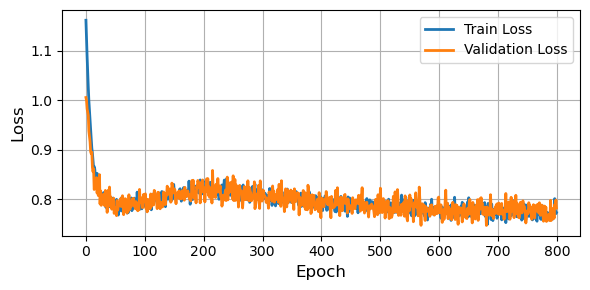

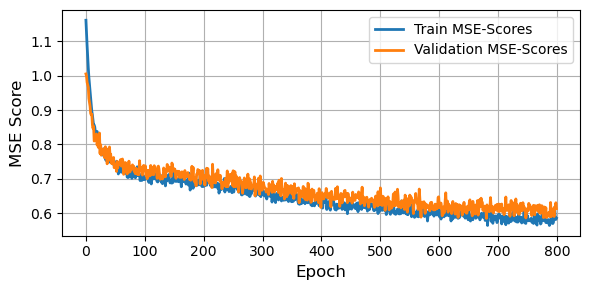

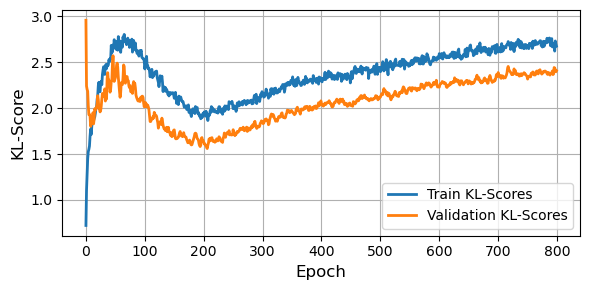

In [12]:
helper_functions.plot_metrics([(train_losses, "Train Loss"), (val_losses, "Validation Loss")], "Loss")
helper_functions.plot_metrics([(train_recons, "Train MSE-Scores"), (val_recons, "Validation MSE-Scores")], "MSE Score")
helper_functions.plot_metrics([(train_kls, "Train KL-Scores"), (val_kls, "Validation KL-Scores")], "KL-Score")

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

latents_mu = []
latents_logvar = []

with torch.no_grad():
    for batch in test_loader:
        x = batch[0].to(device).float()
        _, mu, logvar = model(x)
        latents_mu.append(mu.cpu())
        latents_logvar.append(logvar.cpu())

mu_all = torch.cat(latents_mu, dim=0)           # shape: (n_samples, latent_dim)
logvar_all = torch.cat(latents_logvar, dim=0)   # shape: (n_samples, latent_dim)

# Statistics
mu_std = mu_all.std(dim=0)
logvar_mean = logvar_all.mean(dim=0)
logvar_std = logvar_all.std(dim=0)

print("Std of mu per latent dim:")
print(mu_std)

print("\nMean of logvar per latent dim:")
print(logvar_mean)

print("\nStd of logvar per latent dim:")
print(logvar_std)

Std of mu per latent dim:
tensor([0.6959, 0.8047, 0.9909])

Mean of logvar per latent dim:
tensor([-1.2836, -1.7461, -2.0811])

Std of logvar per latent dim:
tensor([0.1810, 0.2822, 0.1970])


In [11]:
torch.save(model.state_dict(), "VAE0.pth")